<a href="https://colab.research.google.com/github/JongHoB/Data_Mining_Spark_WordCount/blob/main/Colab_0_Spark_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Spark Tutorial

In this tutorial you will learn how to use [Apache Spark](https://spark.apache.org) in local mode on a Colab enviroment.

First writen by [Tiziano Piccardi](http://piccardi.me/) for his Spark Tutorial used in the Applied Data Analysis class at EPFL and adapted for Colab Tutorial in [Stanford CS246](http://cs246.stanford.edu). Now  re-adopted for Ajou CSE3313.   

## Setup

Let's setup Spark on your Colab environment.  Run the cell below!

In [1]:
# install python version of spark
!pip install pyspark
# install (ugrade quietly) PyDrive, a wrapper library of google-api-python-client that simplifies many common Google Drive API tasks
!pip install -U -q PyDrive
#install OpenJDK is a development environment for building applications, applets, and components using the Java programming language
!apt install openjdk-8-jdk-headless -qq
# locate jdk
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.1-py2.py3-none-any.whl size=311285387 sha256=2e6f1d362c981b10416215d3abb03ff9cc87790992b6ce8ffcec0bb32bba9835
  Stored in directory: /root/.cache/pip/wheels/0d/77/a3/ff2f74cc9ab41f8f594dabf0579c2a7c6de920d584206e0834
Successfully built pyspark
The following additional packages will be installed:
  libxtst6 openjdk-8-jre-headless
Suggested packages:
  openjdk-8-demo openjdk-8-source libnss-mdns fonts-dejavu-extra fonts-nanum
  fonts-ipafont-gothic fonts-ipafont-mincho fonts-wqy-microhei
  fonts-wqy-zenhei fonts-indic
The following NEW packages will be installed:
  libxtst6 openjdk-8-jdk-headless openjdk-8-jre-headless
0 upgraded, 3 newly installed, 0 to remove and 17 not upgraded.
Need to get 39.7 MB of archives.
After this operation, 144 MB of additional disk space will be used.
Selecting previously unselected packag

Now we authenticate a Google Drive client to download the file we will be processing in our Spark job.

**Make sure to follow the interactive instructions.**

In [2]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [3]:
id='16cic86KsMUBHjgU4Od0tmz0ggz-FdC2a'
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('Bombing_Operations.json.gz')

id='16cyWlgqu6MiMW-abd6z4Et5KD7y18lhI'
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('Aircraft_Glossary.json.gz')

If you executed the cells above, you should be able to see the files *Bombing_Operations.json.gz* and *Aircraft_Glossary.json.gz* under the "Files" tab on the left panel.

In [4]:
# Let's import the libraries we will need
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pyspark
from pyspark.sql import *
from pyspark.sql.functions import *
# SparkContext is the entry point to any spark functionality.
# SparkConf provides configurations to run a Spark application.
from pyspark import SparkContext, SparkConf

Let's initialize the Spark context. Read more about Spark on Colab at https://platzi.com/tutoriales/2045-spark/10630-configuration-of-apache-spark-amp-spark-ui-using-google-colab/


In [5]:
# create the session
conf = SparkConf().set("spark.ui.port", "4050")

# create the context
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession.builder.getOrCreate()

You can easily check the current version and get the link of the web interface. In the Spark UI, you can monitor the progress of your job and debug the performance bottlenecks (if your Colab is running with a **local runtime**).

In [6]:
spark

If you are running this Colab on the Google hosted runtime, the cell below will create a *ngrok* tunnel (secure introspectable tunnels to localhost) which will allow you to still check the Spark UI.

In [7]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip
get_ipython().system_raw('./ngrok http 4050 &')
!curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

--2023-09-16 13:38:43--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 54.237.133.81, 52.202.168.65, 18.205.222.128, ...
Connecting to bin.equinox.io (bin.equinox.io)|54.237.133.81|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13921656 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  13.28M  59.8MB/s    in 0.2s    

2023-09-16 13:38:44 (59.8 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13921656/13921656]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   
Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/usr/lib/python3.10/json/__init__.py", line 293, in load
    return loads(fp.read(),
  File "/usr/lib/python3.10/json/__init__.py", line 346, in loads
    return _default_decoder.decode(s)
  File "/usr/lib/python3.10/json/decoder.py", line 337, in decode
    obj,

## Data Analysis with Vietnam War Bombing Data


**The dataset describes all the air force operation in during the Vietnam War.**

**Bombing_Operations** [Get the dataset here](https://drive.google.com/open?id=1xbgaCy3nxgulMSL7sSavntmx1W3d9fNn)

- AirCraft: _Aircraft model (example: EC-47)_
- ContryFlyingMission: _Country_
- MissionDate: _Date of the mission_
- OperationSupported: _Supported War operation_ (example: [Operation Rolling Thunder](https://en.wikipedia.org/wiki/Operation_Rolling_Thunder))
- PeriodOfDay: _Day or night_
- TakeoffLocation: _Take off airport_
- TimeOnTarget
- WeaponType
- WeaponsLoadedWeight

**Aircraft_Glossary** [Get the dataset here](https://drive.google.com/file/d/16cyWlgqu6MiMW-abd6z4Et5KD7y18lhI)

- AirCraft: _Aircraft model (example: EC-47)_
- AirCraftName
- AirCraftType

**Dataset Information:**

THOR is a painstakingly cultivated database of historic aerial bombings from World War I through Vietnam. THOR has already proven useful in finding unexploded ordnance in Southeast Asia and improving Air Force combat tactics:
https://www.kaggle.com/usaf/vietnam-war-bombing-operations

###Load and Check the Data

Load the datasets (load json file):

In [8]:
Bombing_Operations = spark.read.json("Bombing_Operations.json.gz")
Aircraft_Glossary = spark.read.json("Aircraft_Glossary.json.gz")

Check the schema via `printSchema()`:

In [9]:
Bombing_Operations.printSchema()

root
 |-- AirCraft: string (nullable = true)
 |-- ContryFlyingMission: string (nullable = true)
 |-- MissionDate: string (nullable = true)
 |-- OperationSupported: string (nullable = true)
 |-- PeriodOfDay: string (nullable = true)
 |-- TakeoffLocation: string (nullable = true)
 |-- TargetCountry: string (nullable = true)
 |-- TimeOnTarget: double (nullable = true)
 |-- WeaponType: string (nullable = true)
 |-- WeaponsLoadedWeight: long (nullable = true)



In [10]:
Aircraft_Glossary.printSchema()

root
 |-- AirCraft: string (nullable = true)
 |-- AirCraftName: string (nullable = true)
 |-- AirCraftType: string (nullable = true)



Get a sample with `take()`:

In [11]:
Bombing_Operations.take(3)

[Row(AirCraft='EC-47', ContryFlyingMission='UNITED STATES OF AMERICA', MissionDate='1971-06-05', OperationSupported=None, PeriodOfDay='D', TakeoffLocation='TAN SON NHUT', TargetCountry='CAMBODIA', TimeOnTarget=1005.0, WeaponType=None, WeaponsLoadedWeight=0),
 Row(AirCraft='EC-47', ContryFlyingMission='UNITED STATES OF AMERICA', MissionDate='1972-12-26', OperationSupported=None, PeriodOfDay='D', TakeoffLocation='NAKHON PHANOM', TargetCountry='SOUTH VIETNAM', TimeOnTarget=530.0, WeaponType=None, WeaponsLoadedWeight=0),
 Row(AirCraft='RF-4', ContryFlyingMission='UNITED STATES OF AMERICA', MissionDate='1973-07-28', OperationSupported=None, PeriodOfDay='D', TakeoffLocation='UDORN AB', TargetCountry='LAOS', TimeOnTarget=730.0, WeaponType=None, WeaponsLoadedWeight=0)]

Get a formatted sample with `show()`:

In [12]:
Aircraft_Glossary.show()

+--------+--------------------+--------------------+
|AirCraft|        AirCraftName|        AirCraftType|
+--------+--------------------+--------------------+
|     A-1|Douglas A-1 Skyra...|         Fighter Jet|
|    A-26|Douglas A-26 Invader|        Light Bomber|
|    A-37|Cessna A-37 Drago...|Light ground-atta...|
|     A-4|McDonnell Douglas...|         Fighter Jet|
|     A-5|North American A-...|          Bomber Jet|
|     A-6|Grumman A-6 Intruder|     Attack Aircraft|
|     A-7|  LTV A-7 Corsair II|     Attack Aircraft|
|  AC-119|Fairchild AC-119 ...|Military Transpor...|
|  AC-123|Fairchild C-123 P...|Military Transpor...|
|  AC-130|Lockheed AC-130 S...|Fixed wing ground...|
|   AC-47|Douglas AC-47 Spooky|Ground attack air...|
|    AH-1| Bell AH-1 HueyCobra|          Helicopter|
|     B-1| Rockwell B-1 Lancer|Heavy strategic b...|
|    B-52| B-52 Stratofortress|    Strategic bomber|
|    B-57|Martin B-57 Canberra|     Tactical Bomber|
|    B-66|Douglas B-66 Dest...|        Light B

In [13]:
print("In total there are {0} operations".format(Bombing_Operations.count()))

In total there are 4400775 operations


### Question 1: Which countries are involved and in how many missions?

Keywords: `Dataframe API`, `SQL`, `group by`, `sort`

Let's group the missions by `ContryFlyingMission` and count how many records exist:

In [14]:
missions_counts = Bombing_Operations.groupBy("ContryFlyingMission")\
                                    .agg(count("*").alias("MissionsCount"))\
                                    .sort(desc("MissionsCount"))
missions_counts.show()

+--------------------+-------------+
| ContryFlyingMission|MissionsCount|
+--------------------+-------------+
|UNITED STATES OF ...|      3708997|
|     VIETNAM (SOUTH)|       622013|
|                LAOS|        32777|
|       KOREA (SOUTH)|        24469|
|           AUSTRALIA|        12519|
+--------------------+-------------+



In this case we used the DataFrame API, but we could rewite the `groupBy` using pure SQL:

In [15]:
Bombing_Operations.createOrReplaceTempView("Bombing_Operations")

query = """
SELECT ContryFlyingMission, count(*) as MissionsCount
FROM Bombing_Operations
GROUP BY ContryFlyingMission
ORDER BY MissionsCount DESC
"""

missions_counts = spark.sql(query)
missions_counts.show()

+--------------------+-------------+
| ContryFlyingMission|MissionsCount|
+--------------------+-------------+
|UNITED STATES OF ...|      3708997|
|     VIETNAM (SOUTH)|       622013|
|                LAOS|        32777|
|       KOREA (SOUTH)|        24469|
|           AUSTRALIA|        12519|
+--------------------+-------------+



Resulting Dataframe is small enough to be moved to Pandas. So let's try that:

In [16]:
missions_count_pd = missions_counts.toPandas()
missions_count_pd.head()

,ContryFlyingMission,MissionsCount
0,UNITED STATES OF AMERICA,3708997
1,VIETNAM (SOUTH),622013
2,LAOS,32777
3,KOREA (SOUTH),24469
4,AUSTRALIA,12519


Let's plot a barchart with the number of missions by country:

Text(0.5, 1.0, 'Number of missions by Country')

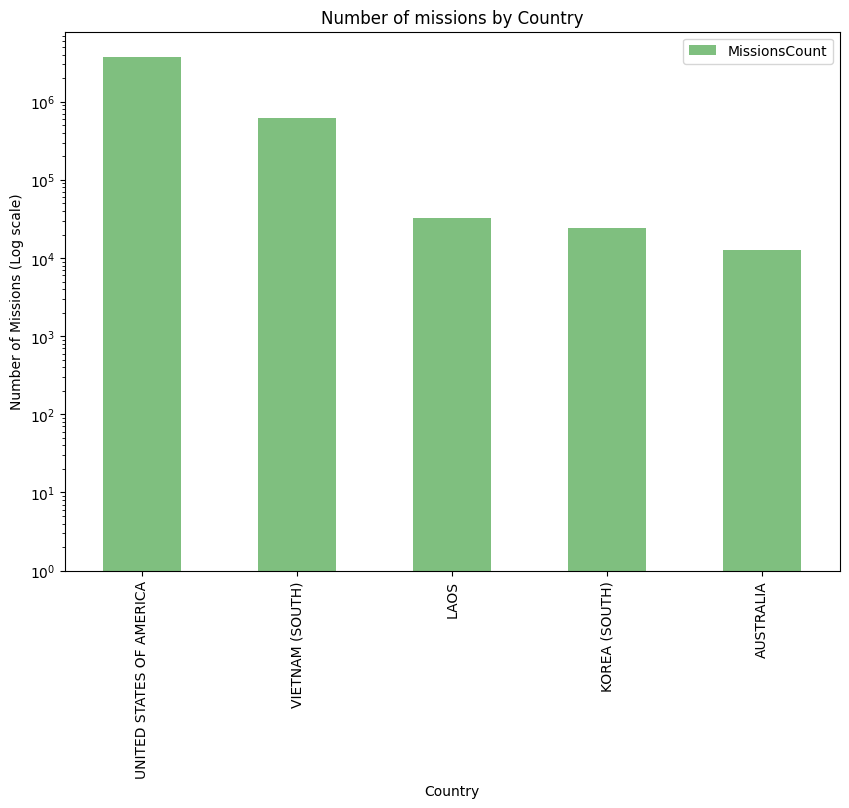

In [20]:
pl = missions_count_pd.plot(kind="bar",
                            x="ContryFlyingMission", y="MissionsCount",
                            figsize=(10, 7), log=True, alpha=0.5, color="green")
pl.set_xlabel("Country")
pl.set_ylabel("Number of Missions (Log scale)")
pl.set_title("Number of missions by Country")

----

### Questions 2: Show the number of missions in time for each of the countries involved.

Keywords: `group by`, `parse date`, `plot`

Let's select the relevant columns:

In [21]:
missions_countries = Bombing_Operations.selectExpr(["to_date(MissionDate) as MissionDate", "ContryFlyingMission"])
missions_countries

DataFrame[MissionDate: date, ContryFlyingMission: string]

The filed MissionDate is converted to a Python `date` object.

Now we can group by `MissionDate` and `ContryFlyingMission` to get the count:

In [22]:
missions_by_date = missions_countries\
                    .groupBy(["MissionDate", "ContryFlyingMission"])\
                    .agg(count("*").alias("MissionsCount"))\
                    .sort(asc("MissionDate")).toPandas()
missions_by_date.head()

,MissionDate,ContryFlyingMission,MissionsCount
0,1965-10-01,UNITED STATES OF AMERICA,447
1,1965-10-02,UNITED STATES OF AMERICA,652
2,1965-10-03,UNITED STATES OF AMERICA,608
3,1965-10-04,UNITED STATES OF AMERICA,532
4,1965-10-05,UNITED STATES OF AMERICA,697


Now we can plot the content with a different series for each country:

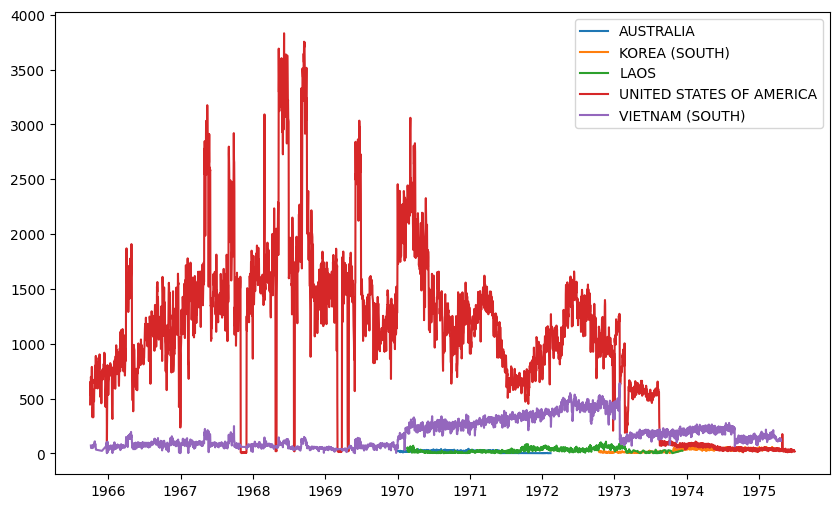

In [23]:
fig = plt.figure(figsize=(10, 6))

# iterate the different groups to create a different series
for country, missions in missions_by_date.groupby("ContryFlyingMission"):
    plt.plot(missions["MissionDate"], missions["MissionsCount"], label=country)

plt.legend(loc='best')

We can observe how South Vietnam increased its missions starting from 1970. The drop in 1973 is motivated by the [Paris Peace Accords](https://en.wikipedia.org/wiki/Paris_Peace_Accords) that took place on January 27th, 1973, to establish peace in Vietnam and end the war.

----

### Question 3: Who bombed this location?

Keywords: `RDD map reduce` `cache` `save results`

We are interested in discovering what was the most common take-off location during that day.

In [24]:
jun_29_operations = Bombing_Operations.where("MissionDate = '1966-06-29' AND TargetCountry='NORTH VIETNAM'")

Which coutries scheduled missions that day?

In [25]:
jun_29_operations.groupBy("ContryFlyingMission").agg(count("*").alias("MissionsCount")).toPandas()

,ContryFlyingMission,MissionsCount
0,VIETNAM (SOUTH),6
1,UNITED STATES OF AMERICA,389


Most of the operation that day were performed by USA airplanes.

In [26]:
jun_29_operations.take(1)

[Row(AirCraft='F-105', ContryFlyingMission='UNITED STATES OF AMERICA', MissionDate='1966-06-29', OperationSupported='STEEL TIGER', PeriodOfDay='D', TakeoffLocation='TAKHLI', TargetCountry='NORTH VIETNAM', TimeOnTarget=310.0, WeaponType='1000LB MK-83', WeaponsLoadedWeight=-1)]

You can specify to cache the content in memory:

In [27]:
jun_29_operations.cache()

DataFrame[AirCraft: string, ContryFlyingMission: string, MissionDate: string, OperationSupported: string, PeriodOfDay: string, TakeoffLocation: string, TargetCountry: string, TimeOnTarget: double, WeaponType: string, WeaponsLoadedWeight: bigint]

Now you can count the number of rows and move the content to the cache:

In [28]:
%time jun_29_operations.count()

CPU times: user 46.2 ms, sys: 6.26 ms, total: 52.4 ms
Wall time: 8.75 s


395

The second time the content is cached and the operation is much faster:

In [29]:
%time jun_29_operations.count()

CPU times: user 3.7 ms, sys: 0 ns, total: 3.7 ms
Wall time: 161 ms


395

You can also save the results on a file...

In [30]:
jun_29_operations.write.mode('overwrite').json("jun_29_operations.json")

... and read from the file:

In [31]:
jun_29_operations = spark.read.json("jun_29_operations.json")

We can use the simple DataFrame API...

In [32]:
TakeoffLocationCounts = jun_29_operations\
                            .groupBy("TakeoffLocation").agg(count("*").alias("MissionsCount"))\
                            .sort(desc("MissionsCount"))
TakeoffLocationCounts.show()

+----------------+-------------+
| TakeoffLocation|MissionsCount|
+----------------+-------------+
|   CONSTELLATION|           87|
|          TAKHLI|           56|
|           KORAT|           55|
|        UDORN AB|           44|
|         UBON AB|           44|
|          DANANG|           35|
|          RANGER|           35|
|    TAN SON NHUT|           26|
|HANCOCK (CVA-19)|           10|
|    CAM RANH BAY|            2|
|         CUBI PT|            1|
+----------------+-------------+



... or the explicit Map/Reduce format with RDDs.

First we emit a pair in the format (Location, 1):

In [33]:
all_locations = jun_29_operations.rdd.map(lambda row: (row.TakeoffLocation, 1))
all_locations.take(3)

[('TAKHLI', 1), ('DANANG', 1), ('CONSTELLATION', 1)]

Then, we sum counters in the reduce step, and we sort by count:

In [34]:
locations_counts_rdd = all_locations.reduceByKey(lambda a, b: a+b).sortBy(lambda r: -r[1])
locations_counts_rdd.take(3)

[('CONSTELLATION', 87), ('TAKHLI', 56), ('KORAT', 55)]

Now we can convert the RDD in dataframe by mapping the pairs to objects of type `Row`

In [35]:
locations_counts_with_schema = locations_counts_rdd.map(lambda r: Row(TakeoffLocation=r[0], MissionsCount=r[1]))
locations_counts = spark.createDataFrame(locations_counts_with_schema)
locations_counts.show()

+----------------+-------------+
| TakeoffLocation|MissionsCount|
+----------------+-------------+
|   CONSTELLATION|           87|
|          TAKHLI|           56|
|           KORAT|           55|
|         UBON AB|           44|
|        UDORN AB|           44|
|          DANANG|           35|
|          RANGER|           35|
|    TAN SON NHUT|           26|
|HANCOCK (CVA-19)|           10|
|    CAM RANH BAY|            2|
|         CUBI PT|            1|
+----------------+-------------+



### Questions 4: What is the most used aircraft type during the Vietnam war (number of missions)?

Keywords: `join` `group by`

Let's check the content of `Aircraft_Glossary`:

In [36]:
Aircraft_Glossary.show(5)

+--------+--------------------+--------------------+
|AirCraft|        AirCraftName|        AirCraftType|
+--------+--------------------+--------------------+
|     A-1|Douglas A-1 Skyra...|         Fighter Jet|
|    A-26|Douglas A-26 Invader|        Light Bomber|
|    A-37|Cessna A-37 Drago...|Light ground-atta...|
|     A-4|McDonnell Douglas...|         Fighter Jet|
|     A-5|North American A-...|          Bomber Jet|
+--------+--------------------+--------------------+
only showing top 5 rows



We are interested in the filed `AirCraftType`.

In [37]:
Bombing_Operations.select("AirCraft").show(5)

+--------+
|AirCraft|
+--------+
|   EC-47|
|   EC-47|
|    RF-4|
|     A-1|
|    A-37|
+--------+
only showing top 5 rows



We can join on the column `AirCraft` of both dataframes.

With Dataframe API:

In [38]:
missions_joined = Bombing_Operations.join(Aircraft_Glossary,
                                          Bombing_Operations.AirCraft == Aircraft_Glossary.AirCraft)
missions_joined

DataFrame[AirCraft: string, ContryFlyingMission: string, MissionDate: string, OperationSupported: string, PeriodOfDay: string, TakeoffLocation: string, TargetCountry: string, TimeOnTarget: double, WeaponType: string, WeaponsLoadedWeight: bigint, AirCraft: string, AirCraftName: string, AirCraftType: string]

We can select only the field we are interested in:

In [39]:
missions_aircrafts = missions_joined.select("AirCraftType")
missions_aircrafts.show(5)

+--------------------+
|        AirCraftType|
+--------------------+
|Military Transpor...|
|Military Transpor...|
|  Fighter bomber jet|
|         Fighter Jet|
|Light ground-atta...|
+--------------------+
only showing top 5 rows



And finally we can group by `AirCraftType` and count:

In [40]:
missions_aircrafts.groupBy("AirCraftType").agg(count("*").alias("MissionsCount"))\
                  .sort(desc("MissionsCount"))\
                  .show()

+--------------------+-------------+
|        AirCraftType|MissionsCount|
+--------------------+-------------+
|  Fighter Jet Bomber|      1073126|
|         Fighter Jet|       882594|
|  Jet Fighter Bomber|       451385|
|     Attack Aircraft|       315246|
|Light ground-atta...|       267457|
|  Fighter bomber jet|       242231|
|Military Transpor...|       228426|
|  Utility Helicopter|       146653|
|    Strategic bomber|        99100|
|     Tactical Bomber|        82219|
|Observation Aircraft|        81820|
|Fixed wing ground...|        75058|
|Ground attack air...|        73843|
|Carrier-based Fig...|        58691|
|   Training Aircraft|        48435|
|       Light fighter|        39999|
|        Light Bomber|        39262|
|Light Tactical Bo...|        34738|
| Light Utility Plane|        28582|
|Observation/ Ligh...|        24491|
+--------------------+-------------+
only showing top 20 rows



In alternative we can rewrite this in pure SQL:

In [41]:
Bombing_Operations.registerTempTable("Bombing_Operations")
Aircraft_Glossary.registerTempTable("Aircraft_Glossary")

query = """
SELECT AirCraftType, count(*) MissionsCount
FROM Bombing_Operations bo
JOIN Aircraft_Glossary ag
ON bo.AirCraft = ag.AirCraft
GROUP BY AirCraftType
ORDER BY MissionsCount DESC
"""

spark.sql(query).show()

/usr/local/lib/python3.10/dist-packages/pyspark/sql/dataframe.py:330: FutureWarning: Deprecated in 2.0, use createOrReplaceTempView instead.
  warnings.warn("Deprecated in 2.0, use createOrReplaceTempView instead.", FutureWarning)


+--------------------+-------------+
|        AirCraftType|MissionsCount|
+--------------------+-------------+
|  Fighter Jet Bomber|      1073126|
|         Fighter Jet|       882594|
|  Jet Fighter Bomber|       451385|
|     Attack Aircraft|       315246|
|Light ground-atta...|       267457|
|  Fighter bomber jet|       242231|
|Military Transpor...|       228426|
|  Utility Helicopter|       146653|
|    Strategic bomber|        99100|
|     Tactical Bomber|        82219|
|Observation Aircraft|        81820|
|Fixed wing ground...|        75058|
|Ground attack air...|        73843|
|Carrier-based Fig...|        58691|
|   Training Aircraft|        48435|
|       Light fighter|        39999|
|        Light Bomber|        39262|
|Light Tactical Bo...|        34738|
| Light Utility Plane|        28582|
|Observation/ Ligh...|        24491|
+--------------------+-------------+
only showing top 20 rows



The aircrafts of type `Fighter Jet Bomber` participated in most of the missions in the Vietnam war.

Note: This dataset would require further cleaning and normalization. See `Fighter Jet Bomber`, `Jet Fighter Bomber`, `Fighter bomber jet`